In [12]:
import numpy as np
import pandas as pd
import matplotlib.image as img
import warnings
warnings.filterwarnings('ignore')

import os
import glob
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
random_seed = 80
learning_rate = 0.001
batch_size = 32
epochs = 100

cpu


# Data processing

- Load data from Cifar10 dataset
- merge traing and testing data

In [14]:
from tqdm import tqdm
X = []       
labels = [] # this is not used in the training
for path in ['./data/cifar10/train/*', './data/cifar10/test/*']:
    for (i, dirname) in enumerate(glob.glob(path)):
        for filename in tqdm(glob.glob(os.path.join(dirname, '*'))):
            file = img.imread(filename)
            X.append(file)
            labels.append(i)

100%|██████████| 1000/1000 [00:00<00:00, 5579.95it/s]


(60000, 32, 32, 3)


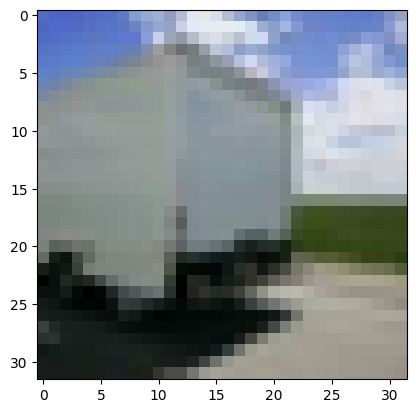

In [15]:
X = np.array(X)

print(X.shape)
plt.imshow(X[11451,:,:,:])

# VAE modeling

- Determine the batch size

In [16]:
from torch.utils.data import DataLoader
X = torch.tensor(X)
X = X.permute(0, 3,1,2)
image_loader = DataLoader(X, batch_size = batch_size, shuffle = True)
# We only care about reconstruction, so we don't need to compute accuracy

### Design VAE's infrastructure
- Required package: pip install torchsummary

In [17]:
from torchsummary import summary
import torch.nn.functional as F

class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args
        
    def forward(self, x):
        return x.view(self.shape)
    
class Trim(nn.Module):
    def __init__(self):
        super(Trim, self).__init__()
    
    def forward(self, x):
        return x[:, :, :32, :32]
    
class VAE(nn.Module):
    def __init__(self):
        
        # [(W−K+2P)/S]+1
        super(VAE, self).__init__()
        # Unfortunately, we cannot have maxunpool2d in nn.Sequential, so we have to write them out

        self.conv1 = nn.Conv2d(3, 32, 3, stride = 2, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride = 2, padding = 1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride = 2, padding = 1)
        self.flatten = nn.Flatten()
        
        self.linear_mean = nn.Linear(2048, 100)
        self.linear_logvar = nn.Linear(2048, 100)

        self.linear = nn.Linear(100, 2048)
        self.reshape = Reshape(-1, 128, 4, 4)
        self.deconv1 = nn.ConvTranspose2d(128, 64, 3, stride = 2, padding=0)
        self.deconv2 = nn.ConvTranspose2d(64, 32, 3, stride = 2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 3, 3, stride = 2, padding=1)
        self.trim = Trim()
    
    def reparameterized(self, mean, var):
        eps = torch.randn(mean.size(0), mean.size(1)).to(device)
        z = mean + eps * torch.exp(var / 2.)
        return z

    def encode(self, x): # Using silu instead of relu here
        x = F.silu(self.conv1(x))
        x = F.silu(self.conv2(x))
        x = self.conv3(x)
        x = self.flatten(x)
        mean = self.linear_mean(x)
        var = self.linear_logvar(x)
        z = self.reparameterized(mean, var)
        return mean, var, z

    def decode(self, z):
        z = self.linear(z)
        z = self.reshape(z)
        z = F.silu(self.deconv1(z))
        z = F.silu(self.deconv2(z))
        z = F.silu(self.deconv3(z))
        z = self.trim(z)
        z = F.sigmoid(z)
        return z
    
    def forward(self, x):
        mean, var, z = self.encode(x)
        z = self.decode(z)
        return mean, var, z

model = VAE().to(device)
model2 = VAE().to(device)
# print(X.shape)

x = torch.randn(1, 3, 32, 32).to(device)
model(x)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             896
            Conv2d-2             [-1, 64, 8, 8]          18,496
            Conv2d-3            [-1, 128, 4, 4]          73,856
           Flatten-4                 [-1, 2048]               0
            Linear-5                  [-1, 100]         204,900
            Linear-6                  [-1, 100]         204,900
            Linear-7                 [-1, 2048]         206,848
           Reshape-8            [-1, 128, 4, 4]               0
   ConvTranspose2d-9             [-1, 64, 9, 9]          73,792
  ConvTranspose2d-10           [-1, 32, 17, 17]          18,464
  ConvTranspose2d-11            [-1, 3, 33, 33]             867
             Trim-12            [-1, 3, 32, 32]               0
Total params: 803,019
Trainable params: 803,019
Non-trainable params: 0
-------------------------------

### Training process

In [18]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
KL_weight = 0.000075 # The KL divergence is much larger than MAE loss, scaling it down

train_losses_total, train_losses_total_avg = [], []
train_losses_reconstruction, train_losses_reconstruction_avg = [], []
train_losses_KL, train_losses_KL_avg = [], []
for epoch in range(epochs):
    train_loss_total = 0.0
    train_loss_reconstruction = 0.0
    train_loss_KL = 0.0
    for images in tqdm(image_loader):
        images = images.to(device)
        mean, var, outputs = model(images)

        optimizer.zero_grad()
        loss1 = criterion(outputs, images)
        loss2 = torch.mean(-0.5 * torch.sum(1 + var - mean**2 - torch.exp(var),axis=1),axis=0) # sum over latent dimension, not batch
        # -0.5 * torch.sum(1 + var - mean**2 - torch.exp(var), axis = 1).mean()
        # loss2 = torch.atan(loss2) / (np.pi / 2) # scaling it to [0,1]        
        loss = loss1  + KL_weight * loss2
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            train_losses_reconstruction.append(loss1.item())
            train_losses_KL.append(loss2.item())
            train_losses_total.append(loss.item())
            train_loss_reconstruction += loss1.item() * images.size(0)
            train_loss_KL += loss2.item() * images.size(0)
            train_loss_total += loss.item() * images.size(0)
    
    train_loss_total /= len(image_loader)
    train_loss_reconstruction /= len(image_loader)
    train_loss_KL /= len(image_loader)
    
    train_losses_total_avg.append(train_loss_total)
    train_losses_reconstruction_avg.append(train_loss_reconstruction)
    train_losses_KL_avg.append(train_loss_KL)
    
    print('-----------------------------------------------------')
    print(f'Epoch{epoch + 1}')
    print(f'Total loss = {train_loss_total:.3f}')
    print(f'Reconstruction loss = {train_loss_reconstruction:.3f}, KL = {train_loss_KL:.3f}')

    log = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict()
    }

    torch.save(log, f'model1_log_{epoch + 1}.pth')     

100%|██████████| 1875/1875 [00:37<00:00, 50.23it/s]


-----------------------------------------------------
Epoch1
Total loss = 1.114
Reconstruction loss = 1.023, KL = 1215.108


100%|██████████| 1875/1875 [00:35<00:00, 53.55it/s]


-----------------------------------------------------
Epoch2
Total loss = 1.023
Reconstruction loss = 0.920, KL = 1370.996


100%|██████████| 1875/1875 [00:35<00:00, 52.97it/s]


-----------------------------------------------------
Epoch3
Total loss = 1.011
Reconstruction loss = 0.905, KL = 1423.594


100%|██████████| 1875/1875 [00:36<00:00, 50.91it/s]


-----------------------------------------------------
Epoch4
Total loss = 1.006
Reconstruction loss = 0.897, KL = 1447.974


100%|██████████| 1875/1875 [00:34<00:00, 55.14it/s]


-----------------------------------------------------
Epoch5
Total loss = 1.002
Reconstruction loss = 0.893, KL = 1460.258


100%|██████████| 1875/1875 [00:32<00:00, 58.35it/s]


-----------------------------------------------------
Epoch6
Total loss = 1.001
Reconstruction loss = 0.890, KL = 1469.290


100%|██████████| 1875/1875 [00:31<00:00, 58.81it/s]


-----------------------------------------------------
Epoch7
Total loss = 0.999
Reconstruction loss = 0.888, KL = 1472.751


100%|██████████| 1875/1875 [00:31<00:00, 59.31it/s]


-----------------------------------------------------
Epoch8
Total loss = 0.998
Reconstruction loss = 0.887, KL = 1475.684


100%|██████████| 1875/1875 [00:32<00:00, 57.70it/s]


-----------------------------------------------------
Epoch9
Total loss = 0.997
Reconstruction loss = 0.886, KL = 1477.816


100%|██████████| 1875/1875 [00:32<00:00, 58.53it/s]


-----------------------------------------------------
Epoch10
Total loss = 0.995
Reconstruction loss = 0.884, KL = 1480.939


100%|██████████| 1875/1875 [00:35<00:00, 53.27it/s]


-----------------------------------------------------
Epoch11
Total loss = 0.995
Reconstruction loss = 0.884, KL = 1478.614


100%|██████████| 1875/1875 [00:33<00:00, 55.21it/s]


-----------------------------------------------------
Epoch12
Total loss = 0.994
Reconstruction loss = 0.883, KL = 1479.714


100%|██████████| 1875/1875 [00:35<00:00, 52.57it/s]


-----------------------------------------------------
Epoch13
Total loss = 0.993
Reconstruction loss = 0.882, KL = 1482.015


100%|██████████| 1875/1875 [00:35<00:00, 53.56it/s]


-----------------------------------------------------
Epoch14
Total loss = 0.993
Reconstruction loss = 0.882, KL = 1481.980


100%|██████████| 1875/1875 [00:33<00:00, 55.53it/s]


-----------------------------------------------------
Epoch15
Total loss = 0.992
Reconstruction loss = 0.881, KL = 1483.103


100%|██████████| 1875/1875 [00:34<00:00, 54.06it/s]


-----------------------------------------------------
Epoch16
Total loss = 0.992
Reconstruction loss = 0.881, KL = 1483.429


100%|██████████| 1875/1875 [00:34<00:00, 54.01it/s]


-----------------------------------------------------
Epoch17
Total loss = 0.992
Reconstruction loss = 0.880, KL = 1483.408


100%|██████████| 1875/1875 [00:34<00:00, 53.97it/s]


-----------------------------------------------------
Epoch18
Total loss = 0.991
Reconstruction loss = 0.880, KL = 1484.708


100%|██████████| 1875/1875 [00:33<00:00, 56.12it/s]


-----------------------------------------------------
Epoch19
Total loss = 0.991
Reconstruction loss = 0.879, KL = 1484.375


100%|██████████| 1875/1875 [00:35<00:00, 52.18it/s]


-----------------------------------------------------
Epoch20
Total loss = 0.991
Reconstruction loss = 0.879, KL = 1485.542


100%|██████████| 1875/1875 [00:35<00:00, 53.35it/s]


-----------------------------------------------------
Epoch21
Total loss = 0.990
Reconstruction loss = 0.879, KL = 1485.456


100%|██████████| 1875/1875 [00:34<00:00, 54.61it/s]


-----------------------------------------------------
Epoch22
Total loss = 0.990
Reconstruction loss = 0.878, KL = 1484.860


100%|██████████| 1875/1875 [00:34<00:00, 55.00it/s]


-----------------------------------------------------
Epoch23
Total loss = 0.990
Reconstruction loss = 0.878, KL = 1486.584


100%|██████████| 1875/1875 [00:33<00:00, 56.20it/s]


-----------------------------------------------------
Epoch24
Total loss = 0.990
Reconstruction loss = 0.878, KL = 1487.390


100%|██████████| 1875/1875 [00:34<00:00, 54.27it/s]


-----------------------------------------------------
Epoch25
Total loss = 0.989
Reconstruction loss = 0.878, KL = 1488.275


100%|██████████| 1875/1875 [00:38<00:00, 48.15it/s]


-----------------------------------------------------
Epoch26
Total loss = 0.989
Reconstruction loss = 0.877, KL = 1488.203


100%|██████████| 1875/1875 [00:41<00:00, 44.94it/s]


-----------------------------------------------------
Epoch27
Total loss = 0.989
Reconstruction loss = 0.877, KL = 1489.102


100%|██████████| 1875/1875 [00:48<00:00, 38.85it/s]


-----------------------------------------------------
Epoch28
Total loss = 0.989
Reconstruction loss = 0.877, KL = 1489.215


100%|██████████| 1875/1875 [00:45<00:00, 40.95it/s]


-----------------------------------------------------
Epoch29
Total loss = 0.989
Reconstruction loss = 0.877, KL = 1487.668


100%|██████████| 1875/1875 [00:46<00:00, 40.03it/s]


-----------------------------------------------------
Epoch30
Total loss = 0.988
Reconstruction loss = 0.877, KL = 1489.042


100%|██████████| 1875/1875 [00:35<00:00, 52.93it/s]


-----------------------------------------------------
Epoch31
Total loss = 0.988
Reconstruction loss = 0.876, KL = 1490.517


100%|██████████| 1875/1875 [00:34<00:00, 54.70it/s]


-----------------------------------------------------
Epoch32
Total loss = 0.988
Reconstruction loss = 0.876, KL = 1488.512


100%|██████████| 1875/1875 [00:36<00:00, 51.53it/s]


-----------------------------------------------------
Epoch33
Total loss = 0.988
Reconstruction loss = 0.876, KL = 1491.173


100%|██████████| 1875/1875 [00:36<00:00, 51.08it/s]


-----------------------------------------------------
Epoch34
Total loss = 0.988
Reconstruction loss = 0.876, KL = 1491.094


100%|██████████| 1875/1875 [00:33<00:00, 56.32it/s]


-----------------------------------------------------
Epoch35
Total loss = 0.988
Reconstruction loss = 0.876, KL = 1492.574


100%|██████████| 1875/1875 [00:40<00:00, 45.98it/s]


-----------------------------------------------------
Epoch36
Total loss = 0.988
Reconstruction loss = 0.876, KL = 1491.692


100%|██████████| 1875/1875 [00:49<00:00, 37.72it/s]


-----------------------------------------------------
Epoch37
Total loss = 0.987
Reconstruction loss = 0.876, KL = 1490.766


100%|██████████| 1875/1875 [00:48<00:00, 38.76it/s]


-----------------------------------------------------
Epoch38
Total loss = 0.987
Reconstruction loss = 0.876, KL = 1490.229


100%|██████████| 1875/1875 [00:48<00:00, 38.78it/s]


-----------------------------------------------------
Epoch39
Total loss = 0.987
Reconstruction loss = 0.876, KL = 1490.440


100%|██████████| 1875/1875 [00:44<00:00, 42.48it/s]


-----------------------------------------------------
Epoch40
Total loss = 0.987
Reconstruction loss = 0.875, KL = 1490.758


100%|██████████| 1875/1875 [00:36<00:00, 51.99it/s]


-----------------------------------------------------
Epoch41
Total loss = 0.987
Reconstruction loss = 0.875, KL = 1489.939


100%|██████████| 1875/1875 [00:35<00:00, 52.83it/s]


-----------------------------------------------------
Epoch42
Total loss = 0.987
Reconstruction loss = 0.875, KL = 1492.120


100%|██████████| 1875/1875 [00:35<00:00, 53.25it/s]


-----------------------------------------------------
Epoch43
Total loss = 0.987
Reconstruction loss = 0.875, KL = 1490.034


100%|██████████| 1875/1875 [00:35<00:00, 53.37it/s]


-----------------------------------------------------
Epoch44
Total loss = 0.987
Reconstruction loss = 0.875, KL = 1492.087


100%|██████████| 1875/1875 [00:35<00:00, 52.54it/s]


-----------------------------------------------------
Epoch45
Total loss = 0.987
Reconstruction loss = 0.875, KL = 1492.594


100%|██████████| 1875/1875 [00:34<00:00, 54.44it/s]


-----------------------------------------------------
Epoch46
Total loss = 0.987
Reconstruction loss = 0.875, KL = 1489.491


100%|██████████| 1875/1875 [00:33<00:00, 55.85it/s]


-----------------------------------------------------
Epoch47
Total loss = 0.987
Reconstruction loss = 0.875, KL = 1492.640


100%|██████████| 1875/1875 [00:34<00:00, 54.57it/s]


-----------------------------------------------------
Epoch48
Total loss = 0.987
Reconstruction loss = 0.875, KL = 1492.937


100%|██████████| 1875/1875 [00:36<00:00, 51.61it/s]


-----------------------------------------------------
Epoch49
Total loss = 0.987
Reconstruction loss = 0.875, KL = 1492.295


100%|██████████| 1875/1875 [00:33<00:00, 55.86it/s]


-----------------------------------------------------
Epoch50
Total loss = 0.986
Reconstruction loss = 0.875, KL = 1491.557


100%|██████████| 1875/1875 [00:36<00:00, 51.75it/s]


-----------------------------------------------------
Epoch51
Total loss = 0.986
Reconstruction loss = 0.875, KL = 1490.481


100%|██████████| 1875/1875 [00:32<00:00, 58.38it/s]


-----------------------------------------------------
Epoch52
Total loss = 0.986
Reconstruction loss = 0.874, KL = 1491.292


100%|██████████| 1875/1875 [01:56<00:00, 16.09it/s]


-----------------------------------------------------
Epoch53
Total loss = 0.986
Reconstruction loss = 0.874, KL = 1489.702


100%|██████████| 1875/1875 [02:24<00:00, 12.94it/s]


-----------------------------------------------------
Epoch54
Total loss = 0.986
Reconstruction loss = 0.874, KL = 1491.758


100%|██████████| 1875/1875 [00:40<00:00, 45.93it/s]


-----------------------------------------------------
Epoch55
Total loss = 0.986
Reconstruction loss = 0.874, KL = 1491.084


100%|██████████| 1875/1875 [02:12<00:00, 14.16it/s]


-----------------------------------------------------
Epoch56
Total loss = 0.986
Reconstruction loss = 0.874, KL = 1492.764


100%|██████████| 1875/1875 [00:48<00:00, 38.92it/s]


-----------------------------------------------------
Epoch57
Total loss = 0.986
Reconstruction loss = 0.874, KL = 1492.948


100%|██████████| 1875/1875 [00:58<00:00, 31.86it/s]


-----------------------------------------------------
Epoch58
Total loss = 0.986
Reconstruction loss = 0.874, KL = 1489.974


100%|██████████| 1875/1875 [06:15<00:00,  4.99it/s] 


-----------------------------------------------------
Epoch59
Total loss = 0.986
Reconstruction loss = 0.874, KL = 1491.945


100%|██████████| 1875/1875 [00:34<00:00, 54.53it/s]


-----------------------------------------------------
Epoch60
Total loss = 0.986
Reconstruction loss = 0.874, KL = 1491.816


100%|██████████| 1875/1875 [00:32<00:00, 57.59it/s]


-----------------------------------------------------
Epoch61
Total loss = 0.986
Reconstruction loss = 0.874, KL = 1491.811


100%|██████████| 1875/1875 [00:34<00:00, 54.13it/s]


-----------------------------------------------------
Epoch62
Total loss = 0.986
Reconstruction loss = 0.874, KL = 1491.851


100%|██████████| 1875/1875 [00:32<00:00, 57.37it/s]


-----------------------------------------------------
Epoch63
Total loss = 0.986
Reconstruction loss = 0.874, KL = 1491.704


100%|██████████| 1875/1875 [00:32<00:00, 57.19it/s]


-----------------------------------------------------
Epoch64
Total loss = 0.986
Reconstruction loss = 0.874, KL = 1491.007


100%|██████████| 1875/1875 [00:32<00:00, 58.45it/s]


-----------------------------------------------------
Epoch65
Total loss = 0.986
Reconstruction loss = 0.874, KL = 1490.326


100%|██████████| 1875/1875 [00:34<00:00, 53.84it/s]


-----------------------------------------------------
Epoch66
Total loss = 0.986
Reconstruction loss = 0.874, KL = 1491.824


100%|██████████| 1875/1875 [00:34<00:00, 54.43it/s]


-----------------------------------------------------
Epoch67
Total loss = 0.985
Reconstruction loss = 0.874, KL = 1491.822


100%|██████████| 1875/1875 [00:34<00:00, 53.73it/s]


-----------------------------------------------------
Epoch68
Total loss = 0.985
Reconstruction loss = 0.874, KL = 1490.512


100%|██████████| 1875/1875 [00:40<00:00, 46.44it/s]


-----------------------------------------------------
Epoch69
Total loss = 0.986
Reconstruction loss = 0.874, KL = 1490.355


100%|██████████| 1875/1875 [00:36<00:00, 51.82it/s]


-----------------------------------------------------
Epoch70
Total loss = 0.985
Reconstruction loss = 0.874, KL = 1491.040


100%|██████████| 1875/1875 [00:36<00:00, 50.69it/s]


-----------------------------------------------------
Epoch71
Total loss = 0.985
Reconstruction loss = 0.874, KL = 1492.224


100%|██████████| 1875/1875 [00:35<00:00, 53.40it/s]


-----------------------------------------------------
Epoch72
Total loss = 0.985
Reconstruction loss = 0.873, KL = 1491.296


100%|██████████| 1875/1875 [00:35<00:00, 52.24it/s]


-----------------------------------------------------
Epoch73
Total loss = 0.985
Reconstruction loss = 0.874, KL = 1491.857


100%|██████████| 1875/1875 [00:36<00:00, 51.33it/s]


-----------------------------------------------------
Epoch74
Total loss = 0.985
Reconstruction loss = 0.874, KL = 1491.116


100%|██████████| 1875/1875 [00:36<00:00, 51.82it/s]


-----------------------------------------------------
Epoch75
Total loss = 0.985
Reconstruction loss = 0.873, KL = 1491.920


100%|██████████| 1875/1875 [00:36<00:00, 51.72it/s]


-----------------------------------------------------
Epoch76
Total loss = 0.985
Reconstruction loss = 0.873, KL = 1492.253


100%|██████████| 1875/1875 [00:35<00:00, 53.28it/s]


-----------------------------------------------------
Epoch77
Total loss = 0.985
Reconstruction loss = 0.873, KL = 1491.927


100%|██████████| 1875/1875 [00:36<00:00, 51.89it/s]


-----------------------------------------------------
Epoch78
Total loss = 0.985
Reconstruction loss = 0.873, KL = 1491.832


100%|██████████| 1875/1875 [00:35<00:00, 52.52it/s]


-----------------------------------------------------
Epoch79
Total loss = 0.985
Reconstruction loss = 0.873, KL = 1491.486


100%|██████████| 1875/1875 [00:36<00:00, 51.38it/s]


-----------------------------------------------------
Epoch80
Total loss = 0.985
Reconstruction loss = 0.873, KL = 1491.598


100%|██████████| 1875/1875 [00:35<00:00, 52.22it/s]


-----------------------------------------------------
Epoch81
Total loss = 0.985
Reconstruction loss = 0.873, KL = 1493.152


100%|██████████| 1875/1875 [00:35<00:00, 52.15it/s]


-----------------------------------------------------
Epoch82
Total loss = 0.985
Reconstruction loss = 0.873, KL = 1492.042


100%|██████████| 1875/1875 [00:36<00:00, 51.87it/s]


-----------------------------------------------------
Epoch83
Total loss = 0.985
Reconstruction loss = 0.873, KL = 1491.921


100%|██████████| 1875/1875 [00:36<00:00, 51.85it/s]


-----------------------------------------------------
Epoch84
Total loss = 0.985
Reconstruction loss = 0.873, KL = 1491.814


100%|██████████| 1875/1875 [00:36<00:00, 52.06it/s]


-----------------------------------------------------
Epoch85
Total loss = 0.985
Reconstruction loss = 0.873, KL = 1491.766


100%|██████████| 1875/1875 [00:36<00:00, 51.19it/s]


-----------------------------------------------------
Epoch86
Total loss = 0.985
Reconstruction loss = 0.873, KL = 1490.454


100%|██████████| 1875/1875 [00:36<00:00, 51.30it/s]


-----------------------------------------------------
Epoch87
Total loss = 0.985
Reconstruction loss = 0.873, KL = 1490.094


100%|██████████| 1875/1875 [00:34<00:00, 54.05it/s]


-----------------------------------------------------
Epoch88
Total loss = 0.985
Reconstruction loss = 0.873, KL = 1490.168


100%|██████████| 1875/1875 [00:36<00:00, 50.89it/s]


-----------------------------------------------------
Epoch89
Total loss = 0.985
Reconstruction loss = 0.873, KL = 1491.497


100%|██████████| 1875/1875 [00:37<00:00, 50.39it/s]


-----------------------------------------------------
Epoch90
Total loss = 0.985
Reconstruction loss = 0.873, KL = 1490.344


100%|██████████| 1875/1875 [00:37<00:00, 50.29it/s]


-----------------------------------------------------
Epoch91
Total loss = 0.985
Reconstruction loss = 0.873, KL = 1492.572


100%|██████████| 1875/1875 [00:37<00:00, 50.66it/s]


-----------------------------------------------------
Epoch92
Total loss = 0.985
Reconstruction loss = 0.873, KL = 1491.110


100%|██████████| 1875/1875 [00:37<00:00, 50.23it/s]


-----------------------------------------------------
Epoch93
Total loss = 0.985
Reconstruction loss = 0.873, KL = 1489.312


100%|██████████| 1875/1875 [00:37<00:00, 50.54it/s]


-----------------------------------------------------
Epoch94
Total loss = 0.985
Reconstruction loss = 0.873, KL = 1491.500


100%|██████████| 1875/1875 [00:37<00:00, 50.25it/s]


-----------------------------------------------------
Epoch95
Total loss = 0.985
Reconstruction loss = 0.873, KL = 1491.111


100%|██████████| 1875/1875 [00:39<00:00, 47.62it/s]


-----------------------------------------------------
Epoch96
Total loss = 0.985
Reconstruction loss = 0.873, KL = 1490.774


100%|██████████| 1875/1875 [00:39<00:00, 48.01it/s]


-----------------------------------------------------
Epoch97
Total loss = 0.985
Reconstruction loss = 0.873, KL = 1489.437


100%|██████████| 1875/1875 [00:38<00:00, 49.21it/s]


-----------------------------------------------------
Epoch98
Total loss = 0.985
Reconstruction loss = 0.873, KL = 1490.239


100%|██████████| 1875/1875 [00:38<00:00, 48.20it/s]


-----------------------------------------------------
Epoch99
Total loss = 0.985
Reconstruction loss = 0.873, KL = 1491.014


100%|██████████| 1875/1875 [00:40<00:00, 46.61it/s]


-----------------------------------------------------
Epoch100
Total loss = 0.985
Reconstruction loss = 0.873, KL = 1491.137


### Learning curve

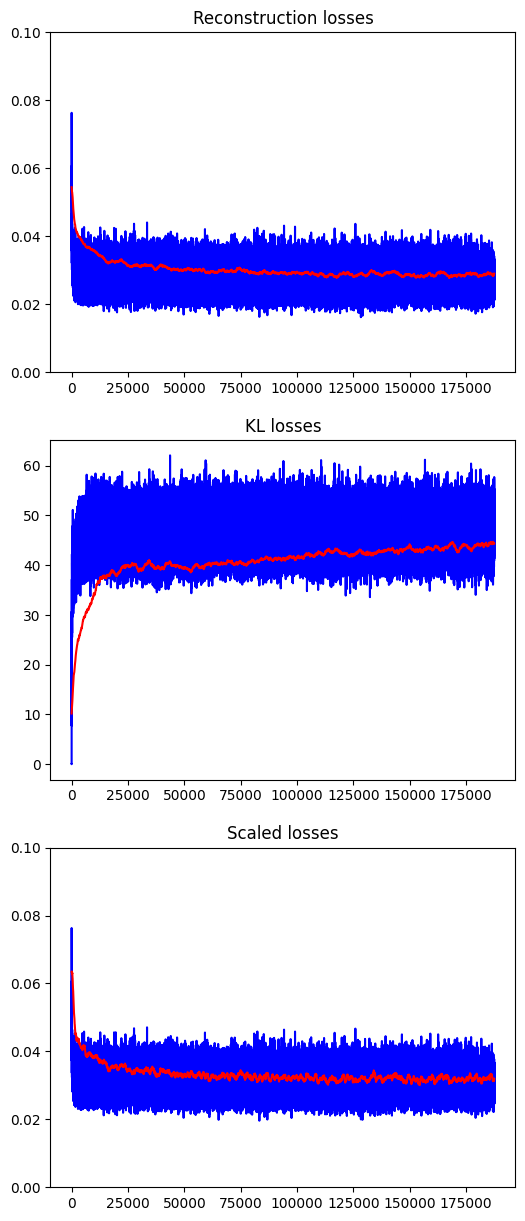

In [21]:
fig, axs = plt.subplots(3, 1, figsize = (6, 15))

train_losses_reconstruction_avg = [np.mean(train_losses_reconstruction[i:i+50]) for i in range(3750)]
axs[0].plot(np.arange(epochs * 1875), train_losses_reconstruction, color = 'b', label = 'mini-batches')
axs[0].plot(np.arange(0, epochs * 1875, 50), train_losses_reconstruction_avg, color = 'r', label = 'running average')
axs[0].set_ylim(0,0.1)
axs[0].set_title('Reconstruction losses')

train_losses_KL_avg = [np.mean(train_losses_KL[i:i+50]) for i in range(3750)]
axs[1].plot(np.arange(epochs * 1875), train_losses_KL, color = 'b', label = 'mini-batches')
axs[1].plot(np.arange(0, epochs * 1875, 50), train_losses_KL_avg, color = 'r', label = 'running average')
axs[1].set_title('KL losses')

train_losses_total_avg = [np.mean(train_losses_total[i:i+20]) for i in range(3750)]
axs[2].plot(np.arange(epochs * 1875), train_losses_total, color = 'b', label = 'mini-batches')
axs[2].plot(np.arange(0, epochs * 1875, 50), train_losses_total_avg, color = 'r', label = 'running average')
axs[2].set_ylim(0,0.1)
axs[2].set_title('Scaled losses')

plt.show()

# Comparison between VAE and AE

### Traning the Autoencoder (without KL in the loss)

In [22]:
model2 = VAE().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr = learning_rate)

train_losses_total, train_losses_total_avg = [], []
train_losses_reconstruction, train_losses_reconstruction_avg = [], []
train_losses_KL, train_losses_KL_avg = [], []
for epoch in range(epochs):
    train_loss_total = 0.0
    train_loss_reconstruction = 0.0
    train_loss_KL = 0.0
    for images in tqdm(image_loader):
        images = images.to(device)
        mean, var, outputs = model2(images)

        optimizer.zero_grad()
        loss1 = criterion(outputs, images)
        loss2 = torch.mean(-0.5 * torch.sum(1 + var - mean**2 - torch.exp(var),axis=1),axis=0) # sum over latent dimension, not batch     
        loss = loss1
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            train_losses_reconstruction.append(loss1.item())
            train_losses_KL.append(loss2.item())
            train_losses_total.append(loss.item())
            train_loss_reconstruction += loss1.item() * images.size(0)
            train_loss_KL += loss2.item() * images.size(0)
            train_loss_total += loss.item() * images.size(0)
    
    train_loss_total /= len(image_loader)
    train_loss_reconstruction /= len(image_loader)
    train_loss_KL /= len(image_loader)
    
    train_losses_total_avg.append(train_loss_total)
    train_losses_reconstruction_avg.append(train_loss_reconstruction)
    train_losses_KL_avg.append(train_loss_KL)
    
    print('-----------------------------------------------------')
    print(f'Epoch{epoch + 1}')
    print(f'Total loss = {train_loss_total:.3f}')
    print(f'Reconstruction loss = {train_loss_reconstruction:.3f}, KL = {train_loss_KL}')

    log = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict()
    }

    torch.save(log, f'model2_log_{epoch + 1}.pth')      

100%|██████████| 1875/1875 [00:35<00:00, 52.82it/s]


-----------------------------------------------------
Epoch1
Total loss = 0.907
Reconstruction loss = 0.907, KL = 14543.411170546977


100%|██████████| 1875/1875 [00:30<00:00, 61.46it/s]


-----------------------------------------------------
Epoch2
Total loss = 0.792
Reconstruction loss = 0.792, KL = 16386.189560416668


100%|██████████| 1875/1875 [00:31<00:00, 59.25it/s]


-----------------------------------------------------
Epoch3
Total loss = 0.784
Reconstruction loss = 0.784, KL = 16352.301671875


100%|██████████| 1875/1875 [00:35<00:00, 52.24it/s]


-----------------------------------------------------
Epoch4
Total loss = 0.780
Reconstruction loss = 0.780, KL = 16424.286422916666


100%|██████████| 1875/1875 [00:32<00:00, 57.45it/s]


-----------------------------------------------------
Epoch5
Total loss = 0.778
Reconstruction loss = 0.778, KL = 16754.419804166668


100%|██████████| 1875/1875 [00:32<00:00, 58.32it/s]


-----------------------------------------------------
Epoch6
Total loss = 0.776
Reconstruction loss = 0.776, KL = 16960.967848958335


100%|██████████| 1875/1875 [00:31<00:00, 60.02it/s]


-----------------------------------------------------
Epoch7
Total loss = 0.775
Reconstruction loss = 0.775, KL = 17196.2693921875


100%|██████████| 1875/1875 [00:31<00:00, 59.79it/s]


-----------------------------------------------------
Epoch8
Total loss = 0.774
Reconstruction loss = 0.774, KL = 17440.66296875


100%|██████████| 1875/1875 [00:30<00:00, 60.54it/s]


-----------------------------------------------------
Epoch9
Total loss = 0.773
Reconstruction loss = 0.773, KL = 17610.7429015625


100%|██████████| 1875/1875 [00:32<00:00, 58.11it/s]


-----------------------------------------------------
Epoch10
Total loss = 0.772
Reconstruction loss = 0.772, KL = 17843.055334375


100%|██████████| 1875/1875 [00:31<00:00, 59.02it/s]


-----------------------------------------------------
Epoch11
Total loss = 0.772
Reconstruction loss = 0.772, KL = 18018.084491145833


100%|██████████| 1875/1875 [00:31<00:00, 59.52it/s]


-----------------------------------------------------
Epoch12
Total loss = 0.771
Reconstruction loss = 0.771, KL = 18093.575153125


100%|██████████| 1875/1875 [00:31<00:00, 59.80it/s]


-----------------------------------------------------
Epoch13
Total loss = 0.771
Reconstruction loss = 0.771, KL = 18237.46541145833


100%|██████████| 1875/1875 [00:32<00:00, 58.26it/s]


-----------------------------------------------------
Epoch14
Total loss = 0.770
Reconstruction loss = 0.770, KL = 18349.198


100%|██████████| 1875/1875 [00:31<00:00, 58.67it/s]


-----------------------------------------------------
Epoch15
Total loss = 0.770
Reconstruction loss = 0.770, KL = 18437.452645833335


100%|██████████| 1875/1875 [00:32<00:00, 57.22it/s]


-----------------------------------------------------
Epoch16
Total loss = 0.770
Reconstruction loss = 0.770, KL = 18580.293138541667


100%|██████████| 1875/1875 [00:32<00:00, 58.11it/s]


-----------------------------------------------------
Epoch17
Total loss = 0.769
Reconstruction loss = 0.769, KL = 18633.322261458332


100%|██████████| 1875/1875 [00:33<00:00, 56.71it/s]


-----------------------------------------------------
Epoch18
Total loss = 0.769
Reconstruction loss = 0.769, KL = 18664.207878125


100%|██████████| 1875/1875 [00:34<00:00, 54.55it/s]


-----------------------------------------------------
Epoch19
Total loss = 0.769
Reconstruction loss = 0.769, KL = 18809.3600375


100%|██████████| 1875/1875 [00:31<00:00, 60.31it/s]


-----------------------------------------------------
Epoch20
Total loss = 0.768
Reconstruction loss = 0.768, KL = 19020.617502083333


100%|██████████| 1875/1875 [00:32<00:00, 57.75it/s]


-----------------------------------------------------
Epoch21
Total loss = 0.768
Reconstruction loss = 0.768, KL = 19100.685263541665


100%|██████████| 1875/1875 [00:31<00:00, 59.13it/s]


-----------------------------------------------------
Epoch22
Total loss = 0.768
Reconstruction loss = 0.768, KL = 19115.452661458334


100%|██████████| 1875/1875 [00:33<00:00, 55.16it/s]


-----------------------------------------------------
Epoch23
Total loss = 0.768
Reconstruction loss = 0.768, KL = 19295.366863541665


100%|██████████| 1875/1875 [00:33<00:00, 55.24it/s]


-----------------------------------------------------
Epoch24
Total loss = 0.768
Reconstruction loss = 0.768, KL = 19423.074708333334


100%|██████████| 1875/1875 [00:38<00:00, 48.33it/s]


-----------------------------------------------------
Epoch25
Total loss = 0.767
Reconstruction loss = 0.767, KL = 19650.911014583333


100%|██████████| 1875/1875 [00:31<00:00, 59.39it/s]


-----------------------------------------------------
Epoch26
Total loss = 0.767
Reconstruction loss = 0.767, KL = 19633.95908958333


100%|██████████| 1875/1875 [00:33<00:00, 55.72it/s]


-----------------------------------------------------
Epoch27
Total loss = 0.767
Reconstruction loss = 0.767, KL = 19760.401179166667


100%|██████████| 1875/1875 [00:36<00:00, 51.01it/s]


-----------------------------------------------------
Epoch28
Total loss = 0.767
Reconstruction loss = 0.767, KL = 19864.28266875


100%|██████████| 1875/1875 [00:40<00:00, 45.92it/s]


-----------------------------------------------------
Epoch29
Total loss = 0.767
Reconstruction loss = 0.767, KL = 19940.965651041668


100%|██████████| 1875/1875 [00:38<00:00, 48.67it/s]


-----------------------------------------------------
Epoch30
Total loss = 0.767
Reconstruction loss = 0.767, KL = 19972.312740625


100%|██████████| 1875/1875 [00:33<00:00, 55.19it/s]


-----------------------------------------------------
Epoch31
Total loss = 0.767
Reconstruction loss = 0.767, KL = 20089.131721875


100%|██████████| 1875/1875 [00:34<00:00, 53.62it/s]


-----------------------------------------------------
Epoch32
Total loss = 0.766
Reconstruction loss = 0.766, KL = 20124.137875


100%|██████████| 1875/1875 [00:34<00:00, 54.18it/s]


-----------------------------------------------------
Epoch33
Total loss = 0.766
Reconstruction loss = 0.766, KL = 20269.573665625


100%|██████████| 1875/1875 [00:41<00:00, 45.53it/s]


-----------------------------------------------------
Epoch34
Total loss = 0.766
Reconstruction loss = 0.766, KL = 20340.287972916667


100%|██████████| 1875/1875 [00:37<00:00, 49.74it/s]


-----------------------------------------------------
Epoch35
Total loss = 0.766
Reconstruction loss = 0.766, KL = 20383.128065625


100%|██████████| 1875/1875 [00:37<00:00, 49.35it/s]


-----------------------------------------------------
Epoch36
Total loss = 0.766
Reconstruction loss = 0.766, KL = 20593.69135625


100%|██████████| 1875/1875 [00:35<00:00, 53.01it/s]


-----------------------------------------------------
Epoch37
Total loss = 0.766
Reconstruction loss = 0.766, KL = 20659.676813541668


100%|██████████| 1875/1875 [00:33<00:00, 55.21it/s]


-----------------------------------------------------
Epoch38
Total loss = 0.766
Reconstruction loss = 0.766, KL = 20790.864154166666


100%|██████████| 1875/1875 [00:33<00:00, 56.48it/s]


-----------------------------------------------------
Epoch39
Total loss = 0.766
Reconstruction loss = 0.766, KL = 20922.846533333333


100%|██████████| 1875/1875 [00:33<00:00, 56.26it/s]


-----------------------------------------------------
Epoch40
Total loss = 0.766
Reconstruction loss = 0.766, KL = 20922.388040625


100%|██████████| 1875/1875 [00:34<00:00, 54.37it/s]


-----------------------------------------------------
Epoch41
Total loss = 0.765
Reconstruction loss = 0.765, KL = 21001.588772916668


100%|██████████| 1875/1875 [00:32<00:00, 57.13it/s]


-----------------------------------------------------
Epoch42
Total loss = 0.765
Reconstruction loss = 0.765, KL = 21159.18607395833


100%|██████████| 1875/1875 [00:37<00:00, 49.67it/s]


-----------------------------------------------------
Epoch43
Total loss = 0.765
Reconstruction loss = 0.765, KL = 21192.526476041665


100%|██████████| 1875/1875 [00:38<00:00, 48.84it/s]


-----------------------------------------------------
Epoch44
Total loss = 0.765
Reconstruction loss = 0.765, KL = 21323.199696875


100%|██████████| 1875/1875 [00:32<00:00, 57.84it/s]


-----------------------------------------------------
Epoch45
Total loss = 0.765
Reconstruction loss = 0.765, KL = 21512.858961458332


100%|██████████| 1875/1875 [00:40<00:00, 46.22it/s]


-----------------------------------------------------
Epoch46
Total loss = 0.765
Reconstruction loss = 0.765, KL = 21577.896372916668


100%|██████████| 1875/1875 [00:33<00:00, 56.10it/s]


-----------------------------------------------------
Epoch47
Total loss = 0.765
Reconstruction loss = 0.765, KL = 21733.319238541666


100%|██████████| 1875/1875 [00:34<00:00, 54.59it/s]


-----------------------------------------------------
Epoch48
Total loss = 0.765
Reconstruction loss = 0.765, KL = 21852.98125


100%|██████████| 1875/1875 [00:33<00:00, 55.59it/s]


-----------------------------------------------------
Epoch49
Total loss = 0.765
Reconstruction loss = 0.765, KL = 21976.861226041667


100%|██████████| 1875/1875 [00:34<00:00, 53.77it/s]


-----------------------------------------------------
Epoch50
Total loss = 0.765
Reconstruction loss = 0.765, KL = 21985.102364583334


100%|██████████| 1875/1875 [00:31<00:00, 60.14it/s]


-----------------------------------------------------
Epoch51
Total loss = 0.765
Reconstruction loss = 0.765, KL = 22190.866269791666


100%|██████████| 1875/1875 [00:33<00:00, 56.29it/s]


-----------------------------------------------------
Epoch52
Total loss = 0.764
Reconstruction loss = 0.764, KL = 22192.044214583333


100%|██████████| 1875/1875 [00:33<00:00, 56.66it/s]


-----------------------------------------------------
Epoch53
Total loss = 0.765
Reconstruction loss = 0.765, KL = 22324.293615625


100%|██████████| 1875/1875 [00:31<00:00, 59.91it/s]


-----------------------------------------------------
Epoch54
Total loss = 0.764
Reconstruction loss = 0.764, KL = 22387.272352083335


100%|██████████| 1875/1875 [00:32<00:00, 56.87it/s]


-----------------------------------------------------
Epoch55
Total loss = 0.764
Reconstruction loss = 0.764, KL = 22412.841713541668


100%|██████████| 1875/1875 [00:31<00:00, 59.38it/s]


-----------------------------------------------------
Epoch56
Total loss = 0.764
Reconstruction loss = 0.764, KL = 22693.111025


100%|██████████| 1875/1875 [00:32<00:00, 57.68it/s]


-----------------------------------------------------
Epoch57
Total loss = 0.764
Reconstruction loss = 0.764, KL = 22678.69705625


100%|██████████| 1875/1875 [00:31<00:00, 59.89it/s]


-----------------------------------------------------
Epoch58
Total loss = 0.764
Reconstruction loss = 0.764, KL = 22740.897922916665


100%|██████████| 1875/1875 [00:34<00:00, 53.63it/s]


-----------------------------------------------------
Epoch59
Total loss = 0.764
Reconstruction loss = 0.764, KL = 22815.144051041665


100%|██████████| 1875/1875 [00:33<00:00, 55.17it/s]


-----------------------------------------------------
Epoch60
Total loss = 0.764
Reconstruction loss = 0.764, KL = 22970.37828125


100%|██████████| 1875/1875 [00:32<00:00, 56.88it/s]


-----------------------------------------------------
Epoch61
Total loss = 0.764
Reconstruction loss = 0.764, KL = 22841.297164583335


100%|██████████| 1875/1875 [00:31<00:00, 59.37it/s]


-----------------------------------------------------
Epoch62
Total loss = 0.764
Reconstruction loss = 0.764, KL = 23071.517740625


100%|██████████| 1875/1875 [00:33<00:00, 55.79it/s]


-----------------------------------------------------
Epoch63
Total loss = 0.764
Reconstruction loss = 0.764, KL = 23089.701020833334


100%|██████████| 1875/1875 [00:32<00:00, 57.57it/s]


-----------------------------------------------------
Epoch64
Total loss = 0.764
Reconstruction loss = 0.764, KL = 23274.119779166667


100%|██████████| 1875/1875 [00:31<00:00, 58.89it/s]


-----------------------------------------------------
Epoch65
Total loss = 0.764
Reconstruction loss = 0.764, KL = 23306.838823958333


100%|██████████| 1875/1875 [00:33<00:00, 56.01it/s]


-----------------------------------------------------
Epoch66
Total loss = 0.764
Reconstruction loss = 0.764, KL = 23367.886873958334


100%|██████████| 1875/1875 [00:32<00:00, 57.49it/s]


-----------------------------------------------------
Epoch67
Total loss = 0.764
Reconstruction loss = 0.764, KL = 23607.766357291668


100%|██████████| 1875/1875 [00:33<00:00, 56.42it/s]


-----------------------------------------------------
Epoch68
Total loss = 0.764
Reconstruction loss = 0.764, KL = 23579.43280625


100%|██████████| 1875/1875 [00:31<00:00, 59.44it/s]


-----------------------------------------------------
Epoch69
Total loss = 0.764
Reconstruction loss = 0.764, KL = 23569.024654166667


100%|██████████| 1875/1875 [00:33<00:00, 56.05it/s]


-----------------------------------------------------
Epoch70
Total loss = 0.764
Reconstruction loss = 0.764, KL = 23744.313459375


100%|██████████| 1875/1875 [00:36<00:00, 52.06it/s]


-----------------------------------------------------
Epoch71
Total loss = 0.764
Reconstruction loss = 0.764, KL = 23738.5881625


100%|██████████| 1875/1875 [00:34<00:00, 54.73it/s]


-----------------------------------------------------
Epoch72
Total loss = 0.764
Reconstruction loss = 0.764, KL = 23894.462833333335


100%|██████████| 1875/1875 [00:33<00:00, 56.60it/s]


-----------------------------------------------------
Epoch73
Total loss = 0.764
Reconstruction loss = 0.764, KL = 23942.404411458334


100%|██████████| 1875/1875 [00:33<00:00, 56.76it/s]


-----------------------------------------------------
Epoch74
Total loss = 0.764
Reconstruction loss = 0.764, KL = 24076.142697916668


100%|██████████| 1875/1875 [00:34<00:00, 54.71it/s]


-----------------------------------------------------
Epoch75
Total loss = 0.764
Reconstruction loss = 0.764, KL = 24160.28260625


100%|██████████| 1875/1875 [00:34<00:00, 54.70it/s]


-----------------------------------------------------
Epoch76
Total loss = 0.764
Reconstruction loss = 0.764, KL = 24151.147183333334


100%|██████████| 1875/1875 [00:33<00:00, 55.29it/s]


-----------------------------------------------------
Epoch77
Total loss = 0.763
Reconstruction loss = 0.763, KL = 24166.519634375


100%|██████████| 1875/1875 [00:33<00:00, 56.74it/s]


-----------------------------------------------------
Epoch78
Total loss = 0.763
Reconstruction loss = 0.763, KL = 24265.208302083334


100%|██████████| 1875/1875 [00:33<00:00, 56.61it/s]


-----------------------------------------------------
Epoch79
Total loss = 0.763
Reconstruction loss = 0.763, KL = 24268.226357291667


100%|██████████| 1875/1875 [00:32<00:00, 56.82it/s]


-----------------------------------------------------
Epoch80
Total loss = 0.763
Reconstruction loss = 0.763, KL = 24396.068469791666


100%|██████████| 1875/1875 [00:36<00:00, 51.70it/s]


-----------------------------------------------------
Epoch81
Total loss = 0.763
Reconstruction loss = 0.763, KL = 24599.425932291666


100%|██████████| 1875/1875 [00:34<00:00, 53.85it/s]


-----------------------------------------------------
Epoch82
Total loss = 0.763
Reconstruction loss = 0.763, KL = 24540.657996875


100%|██████████| 1875/1875 [00:34<00:00, 54.04it/s]


-----------------------------------------------------
Epoch83
Total loss = 0.763
Reconstruction loss = 0.763, KL = 24792.782780208334


100%|██████████| 1875/1875 [00:36<00:00, 51.29it/s]


-----------------------------------------------------
Epoch84
Total loss = 0.763
Reconstruction loss = 0.763, KL = 24563.235704166666


100%|██████████| 1875/1875 [00:33<00:00, 55.65it/s]


-----------------------------------------------------
Epoch85
Total loss = 0.763
Reconstruction loss = 0.763, KL = 24804.65946875


100%|██████████| 1875/1875 [00:35<00:00, 52.22it/s]


-----------------------------------------------------
Epoch86
Total loss = 0.763
Reconstruction loss = 0.763, KL = 24724.684873958333


100%|██████████| 1875/1875 [00:33<00:00, 55.19it/s]


-----------------------------------------------------
Epoch87
Total loss = 0.763
Reconstruction loss = 0.763, KL = 25134.88061770833


100%|██████████| 1875/1875 [00:35<00:00, 53.49it/s]


-----------------------------------------------------
Epoch88
Total loss = 0.763
Reconstruction loss = 0.763, KL = 25184.060920833334


100%|██████████| 1875/1875 [00:34<00:00, 53.89it/s]


-----------------------------------------------------
Epoch89
Total loss = 0.763
Reconstruction loss = 0.763, KL = 25254.283604166667


100%|██████████| 1875/1875 [00:33<00:00, 55.28it/s]


-----------------------------------------------------
Epoch90
Total loss = 0.763
Reconstruction loss = 0.763, KL = 25330.269260416666


100%|██████████| 1875/1875 [00:34<00:00, 53.70it/s]


-----------------------------------------------------
Epoch91
Total loss = 0.763
Reconstruction loss = 0.763, KL = 25276.770629166665


100%|██████████| 1875/1875 [00:34<00:00, 53.82it/s]


-----------------------------------------------------
Epoch92
Total loss = 0.763
Reconstruction loss = 0.763, KL = 25170.3301875


100%|██████████| 1875/1875 [00:34<00:00, 54.42it/s]


-----------------------------------------------------
Epoch93
Total loss = 0.763
Reconstruction loss = 0.763, KL = 25116.707210416665


100%|██████████| 1875/1875 [00:32<00:00, 56.90it/s]


-----------------------------------------------------
Epoch94
Total loss = 0.763
Reconstruction loss = 0.763, KL = 25672.855707291666


100%|██████████| 1875/1875 [00:38<00:00, 49.24it/s]


-----------------------------------------------------
Epoch95
Total loss = 0.763
Reconstruction loss = 0.763, KL = 25534.888788541666


100%|██████████| 1875/1875 [00:41<00:00, 45.31it/s]


-----------------------------------------------------
Epoch96
Total loss = 0.763
Reconstruction loss = 0.763, KL = 25504.3162125


100%|██████████| 1875/1875 [00:40<00:00, 46.44it/s]


-----------------------------------------------------
Epoch97
Total loss = 0.763
Reconstruction loss = 0.763, KL = 25715.469021875


100%|██████████| 1875/1875 [00:37<00:00, 49.52it/s]


-----------------------------------------------------
Epoch98
Total loss = 0.763
Reconstruction loss = 0.763, KL = 25568.105173958334


100%|██████████| 1875/1875 [00:34<00:00, 54.50it/s]


-----------------------------------------------------
Epoch99
Total loss = 0.763
Reconstruction loss = 0.763, KL = 25784.964080208334


100%|██████████| 1875/1875 [00:32<00:00, 57.06it/s]

-----------------------------------------------------
Epoch100
Total loss = 0.763
Reconstruction loss = 0.763, KL = 25689.871720833333


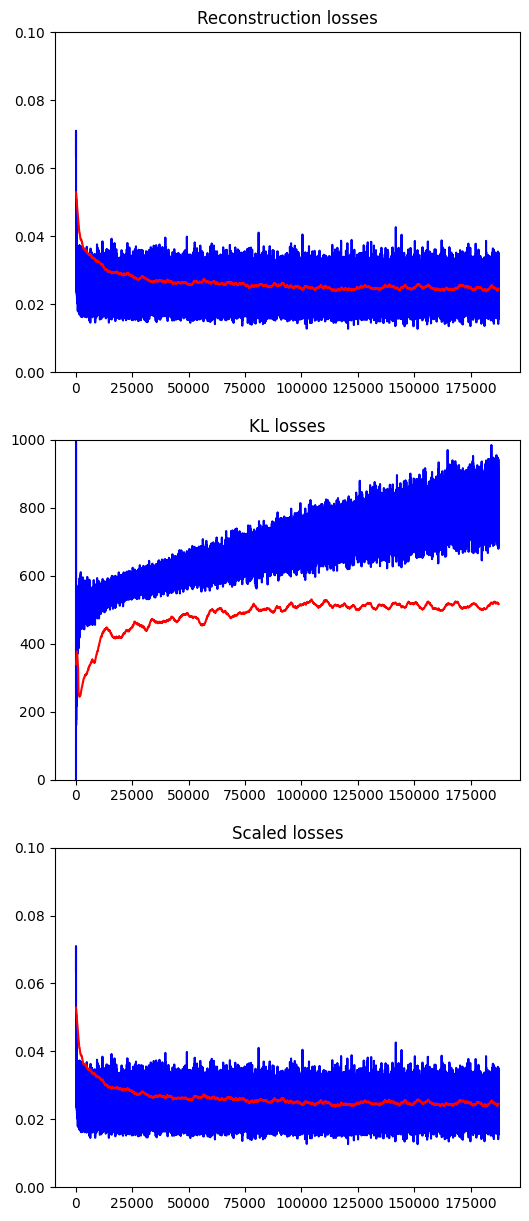

In [25]:
fig, axs = plt.subplots(3, 1, figsize = (6, 15))

train_losses_reconstruction_avg = [np.mean(train_losses_reconstruction[i:i+50]) for i in range(3750)]
axs[0].plot(np.arange(epochs * 1875), train_losses_reconstruction, color = 'b', label = 'mini-batches')
axs[0].plot(np.arange(0, epochs * 1875, 50), train_losses_reconstruction_avg, color = 'r', label = 'running average')
axs[0].set_ylim(0,0.1)
axs[0].set_title('Reconstruction losses')

train_losses_KL_avg = [np.mean(train_losses_KL[i:i+50]) for i in range(3750)]
axs[1].plot(np.arange(epochs * 1875), train_losses_KL, color = 'b', label = 'mini-batches')
axs[1].plot(np.arange(0, epochs * 1875, 50), train_losses_KL_avg, color = 'r', label = 'running average')
axs[1].set_ylim(0,1000)
axs[1].set_title('KL losses')

train_losses_total_avg = [np.mean(train_losses_total[i:i+50]) for i in range(3750)]
axs[2].plot(np.arange(epochs * 1875), train_losses_total, color = 'b', label = 'mini-batches')
axs[2].plot(np.arange(0, epochs * 1875, 50), train_losses_total_avg, color = 'r', label = 'running average')
axs[2].set_ylim(0,0.1)
axs[2].set_title('Scaled losses')

plt.show()

### Generated image by VAE

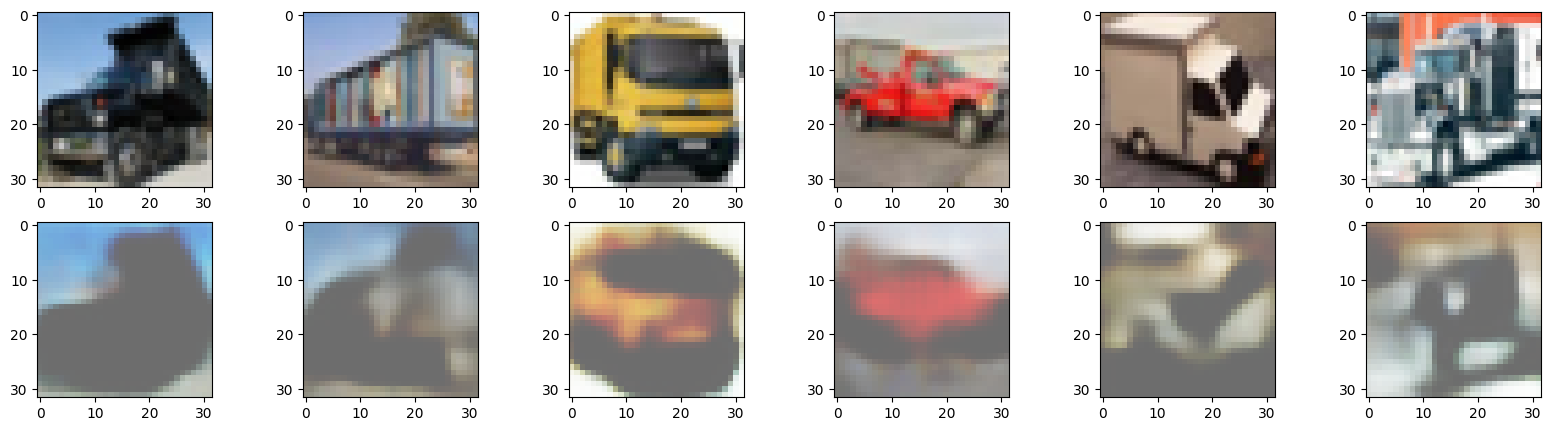

In [53]:
fig, axs = plt.subplots(2, 6, figsize = (20, 5))
for i in range(6):
    axs[0][i].imshow(X[i+10000,:,:,:].permute(1,2,0))
_, _, new_fig = model(X[10000:10006, :, :, :].to(device))
for i in range(6):
    axs[1][i].imshow(new_fig[i].permute(1,2,0).cpu().detach().numpy())

### Output of AE

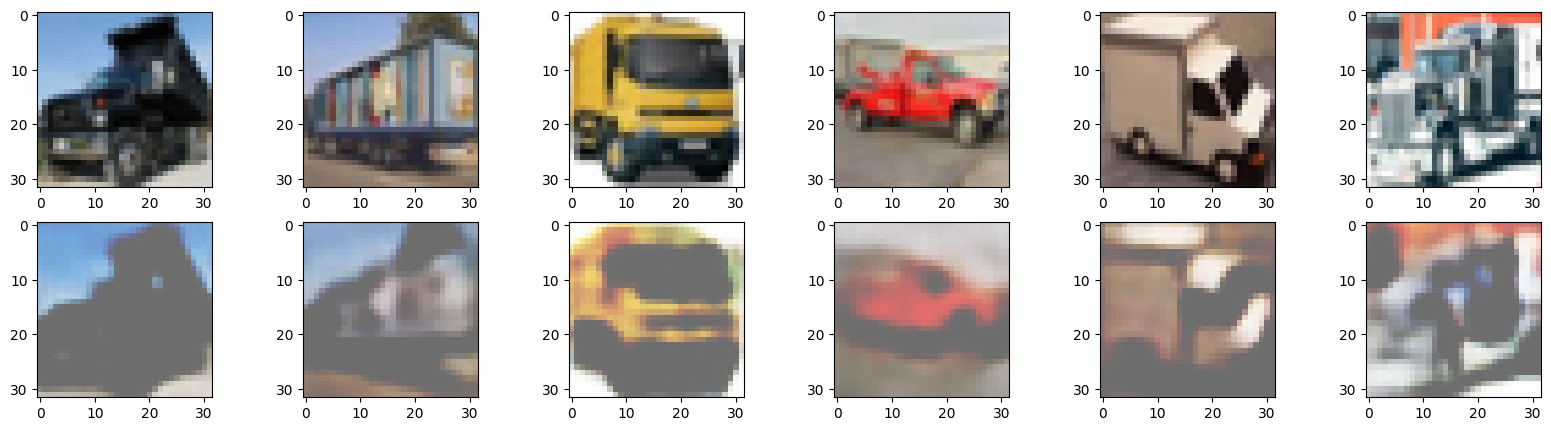

In [54]:
fig, axs = plt.subplots(2, 6, figsize = (20, 5))
for i in range(6):
    axs[0][i].imshow(X[i+10000,:,:,:].permute(1,2,0))
_, _, new_fig = model2(X[10000:10006, :, :, :].to(device))
for i in range(6):
    axs[1][i].imshow(new_fig[i].permute(1,2,0).cpu().detach().numpy())

### Latent Space

Text(0.5, 1.0, 'comparison between the latent spaces')

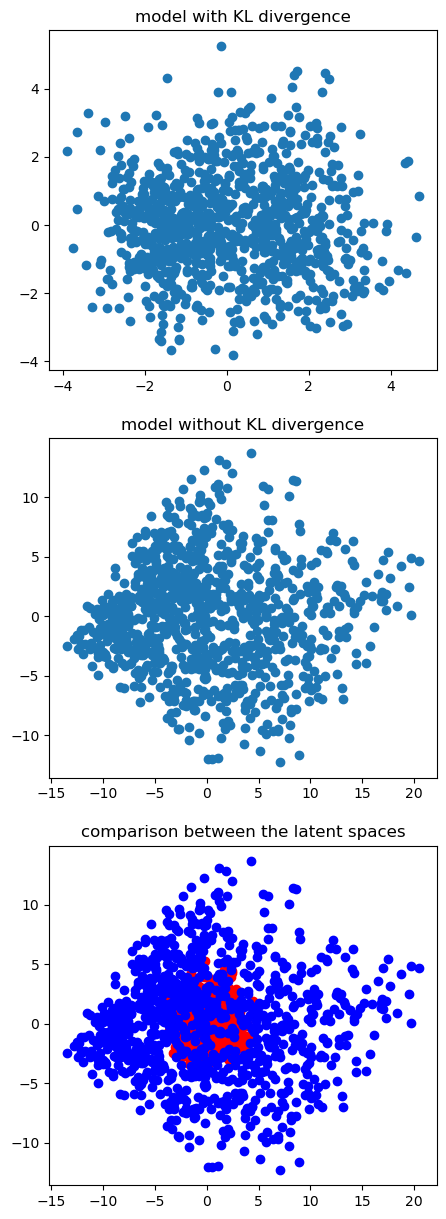

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)

_,_,latent_model1 = model.encode(X[:1000].to(device))
_,_,latent_model2 = model2.encode(X[:1000].to(device))
latent_model1 = latent_model1.cpu().detach().numpy()
latent_model2 = latent_model2.cpu().detach().numpy()

fig, axs = plt.subplots(3, figsize = (5, 15))
plot_X_1 = pca.fit_transform(latent_model1)
axs[0].scatter(plot_X_1[:,0], plot_X_1[:,1])
axs[0].set_title('model with KL divergence')
plot_X_2 = pca.fit_transform(latent_model2)
axs[1].scatter(plot_X_2[:, 0], plot_X_2[:, 1])
axs[1].set_title('model without KL divergence')

axs[2].scatter(plot_X_1[:,0], plot_X_1[:, 1], color = 'r')
axs[2].scatter(plot_X_2[:,0], plot_X_2[:, 1], color = 'b')
axs[2].set_title('comparison between the latent spaces')

### Generating 60 images using VAE

torch.Size([60, 3, 32, 32])


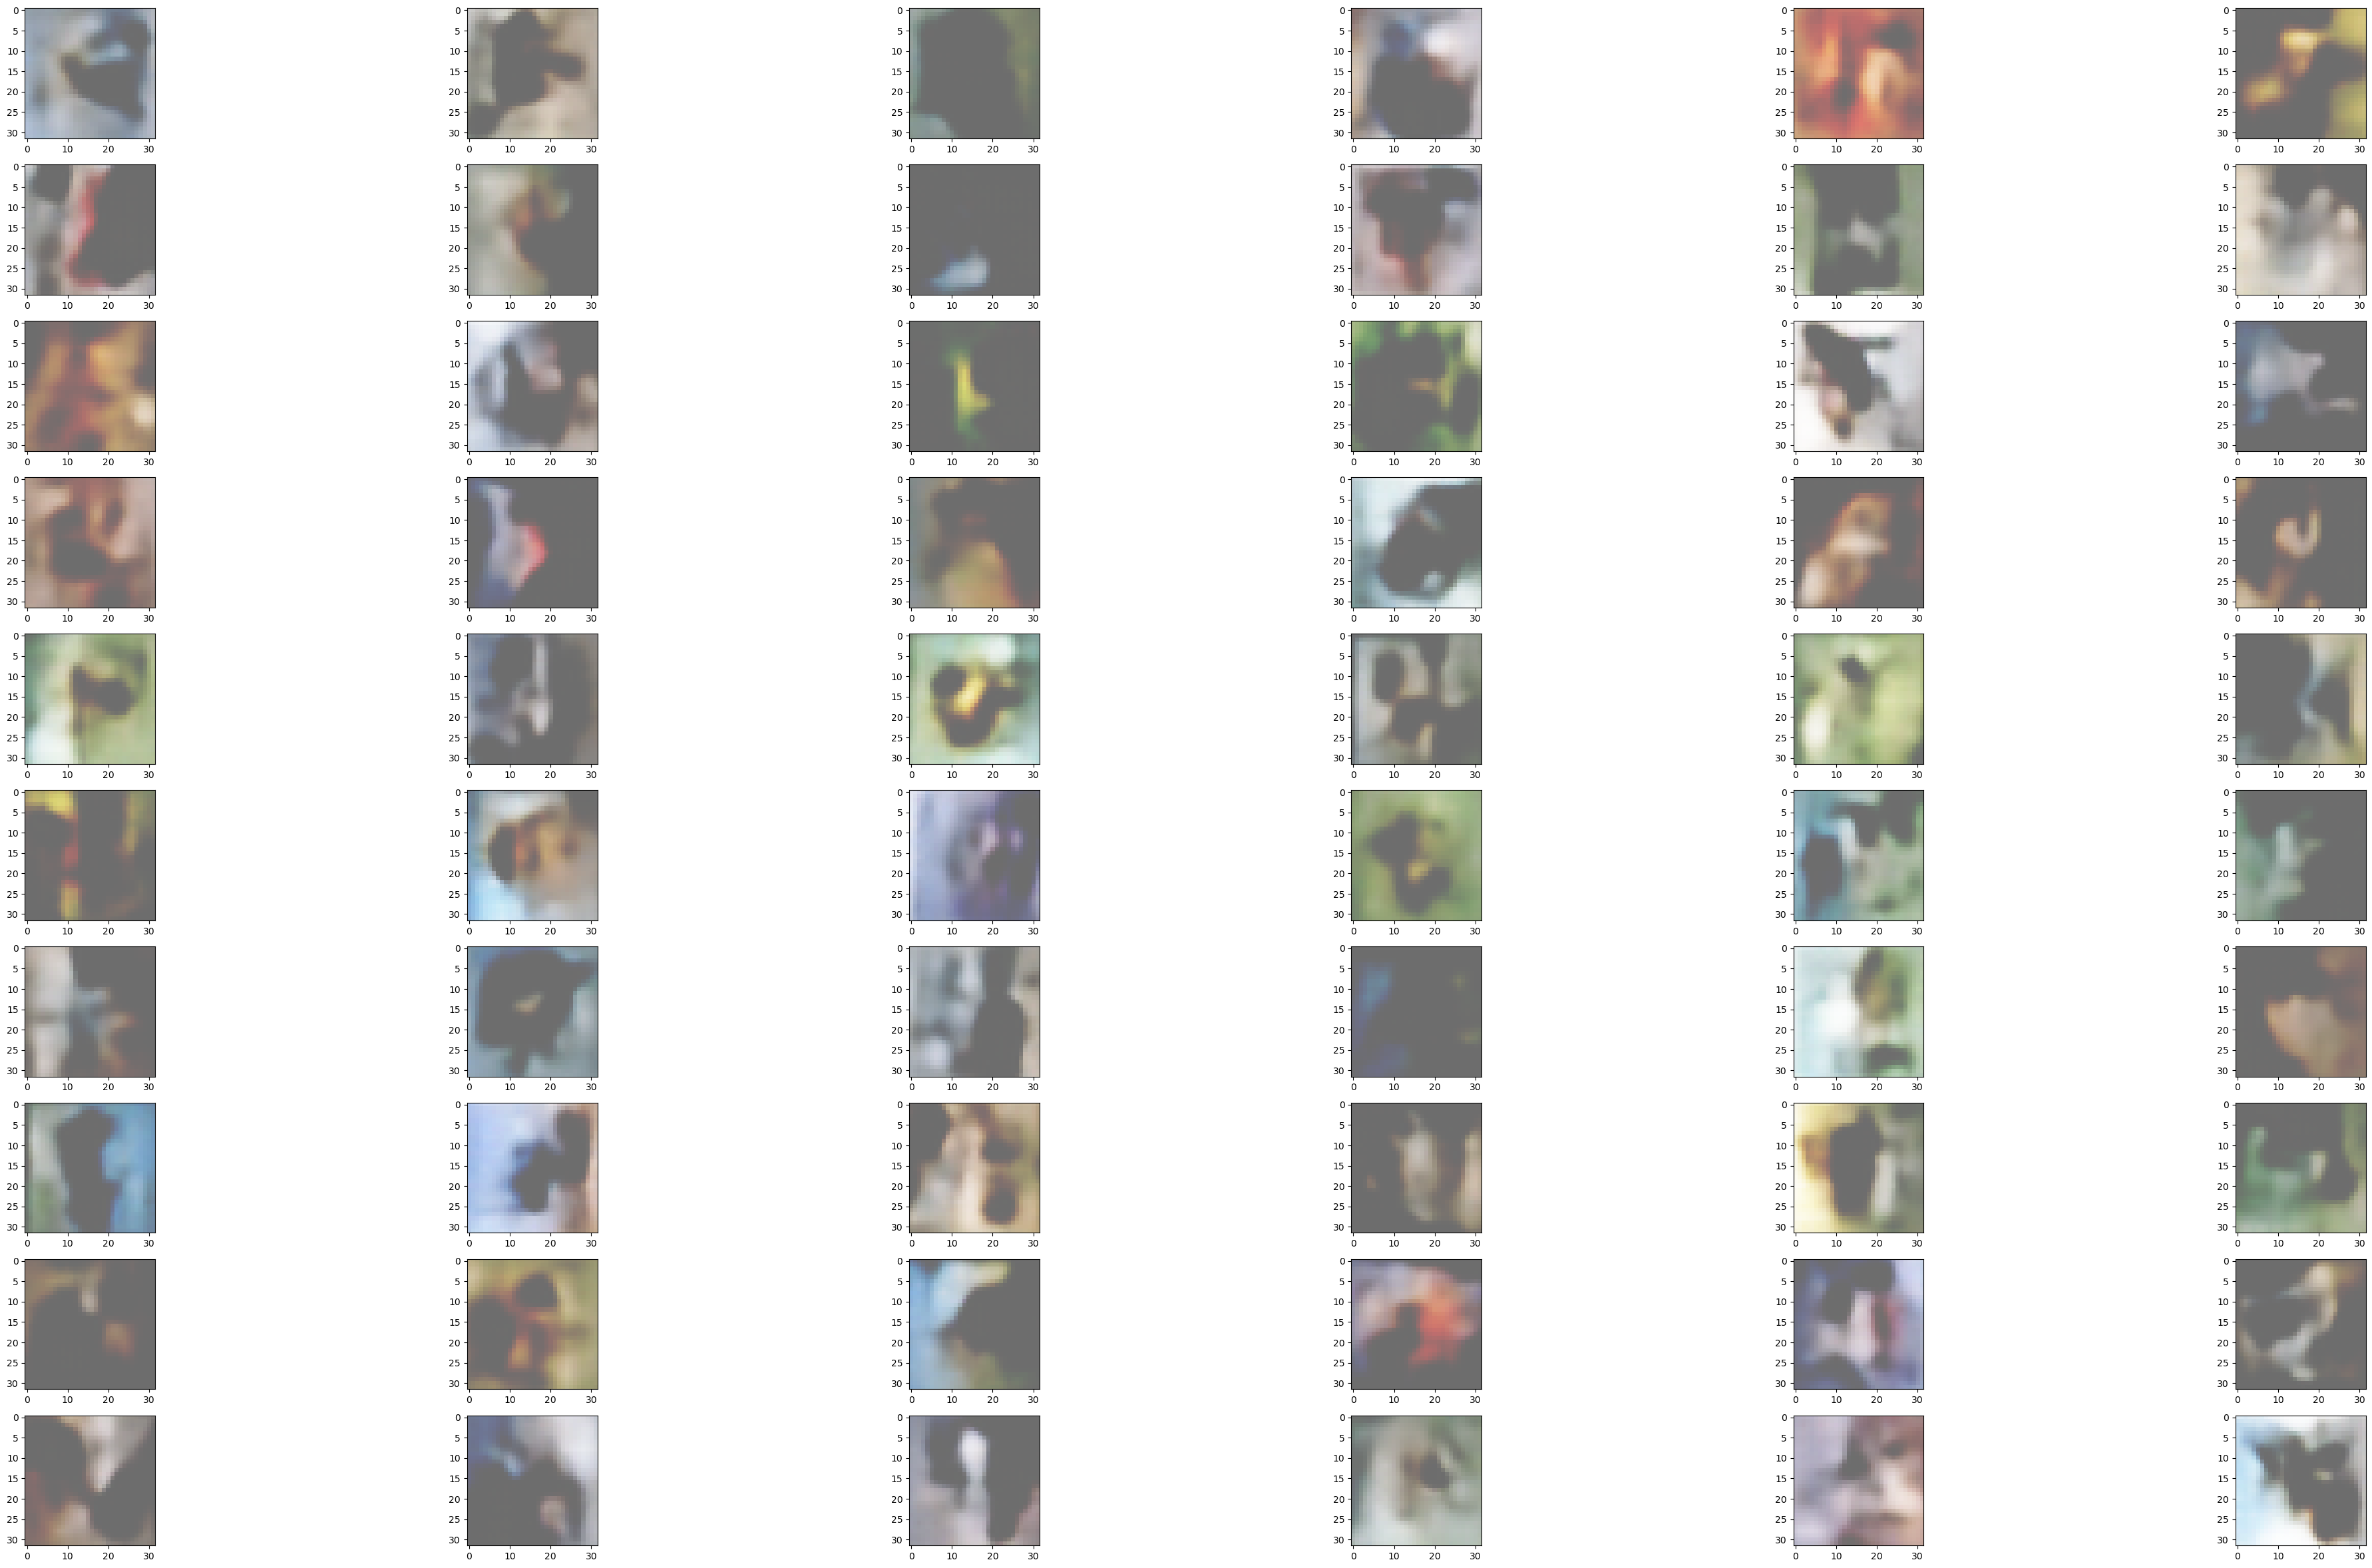

In [ ]:
fig, axs = plt.subplots(10,6, figsize = (50, 30))

names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
sixty_images_latent = torch.randn(60, 100).to(device)
sixty_images = model.decode(sixty_images_latent)
print(sixty_images.shape)
sixty_images = sixty_images.permute(0, 3, 2, 1).cpu().detach().numpy()

for i in range(10):
    for j in range(6):
        idx = (6) * (i-1) + (j)
        axs[i][j].imshow(sixty_images[idx])

### Generating 60 images using AE

torch.Size([60, 3, 32, 32])


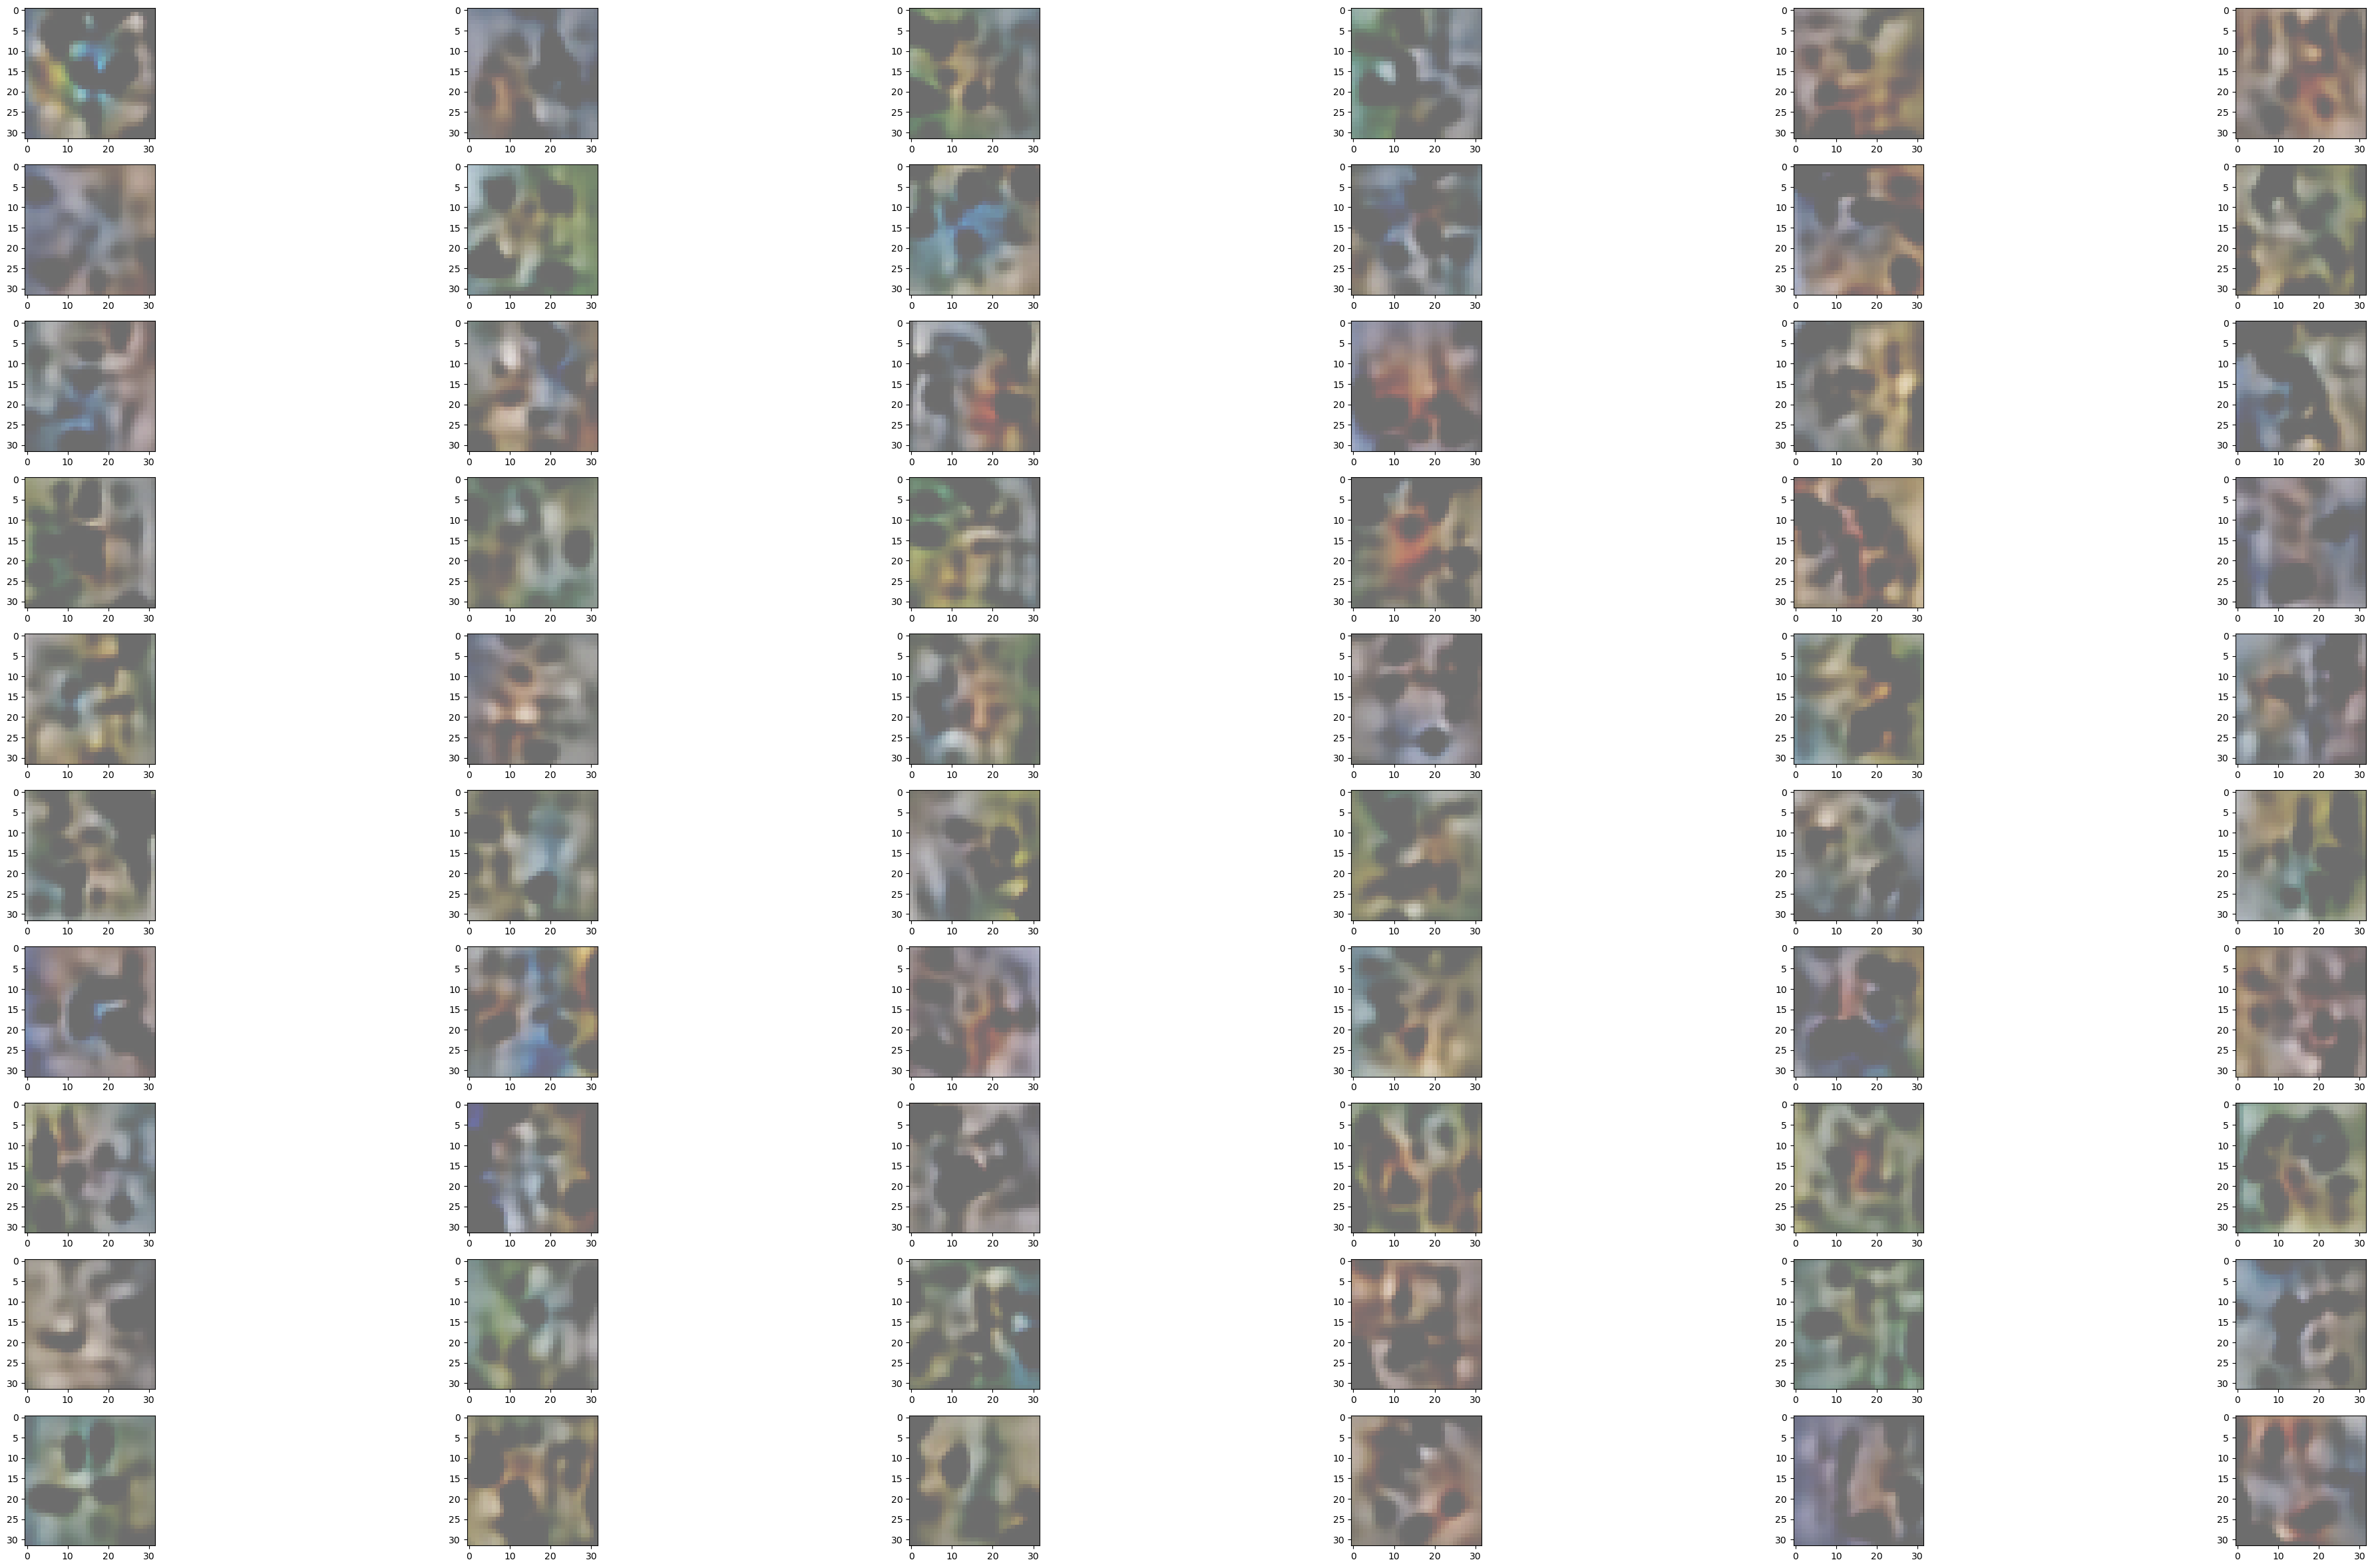

In [ ]:
fig, axs = plt.subplots(10,6, figsize = (50, 30))

names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
sixty_images_latent = torch.randn(60, 100).to(device)
sixty_images = model2.decode(sixty_images_latent)
print(sixty_images.shape)
sixty_images = sixty_images.permute(0, 3, 2, 1).cpu().detach().numpy()

for i in range(10):
    for j in range(6):
        idx = (6) * (i-1) + (j)
        axs[i][j].imshow(sixty_images[idx])

# Save Models

In [ ]:
torch.save(model.state_dict(), './model/model1.pth')
torch.save(model2.state_dict(), './model/model2.pth')
print("Saved model1 and model2 successfully.")

Saved model1 and model2 successfully.
